In [1]:
import torchvision
import torchvision.transforms as transforms
import os
import yaml
import matplotlib.pyplot as plt
import numpy as np

/home/coartix/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
os.chdir('../')
from DataAugmentation import DataAugmentation
from utils import Config

In [3]:

with open("configs/cifar10_base.yml") as f:
        yml_dict = yaml.load(f, Loader=yaml.FullLoader)
config = Config(yml_dict)

In [4]:
data_aug = DataAugmentation(
    config.img_size,
    config.global_crop_ratio,
    config.local_crop_ratio,
    config.nb_local_crops,
    config.dataset_means,
    config.dataset_stds
)

dataset_original = torchvision.datasets.CIFAR10(
    root=config.original_dataset_path,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

dataset_transformed = torchvision.datasets.CIFAR10(
    root=config.test_dataset_path,
    train=False,
    transform=data_aug,
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def imshow(imgs):
    def rescale_img(image):
        image = image - image.min()
        image = image / image.max()
        return image

    if isinstance(imgs, list):
        print("Global views:")
        fig, axs = plt.subplots(1, min(len(imgs), 2), figsize=(10, 5))
        for i in range(2):
            npimg = rescale_img(imgs[i].numpy())
            axs[i].imshow(np.transpose(npimg, (1, 2, 0)))
            axs[i].axis('off')
        plt.show()

        print("Local views:")
        if len(imgs) > 2:
            fig, axs = plt.subplots(1, len(imgs) - 2, figsize=(15, 5))
            for i in range(2, len(imgs)):
                npimg = rescale_img(imgs[i].numpy())
                axs[i - 2].imshow(np.transpose(npimg, (1, 2, 0)))
                axs[i - 2].axis('off')
            plt.show()
    else:
        npimg = rescale_img(imgs.numpy())
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
        plt.show()

Original Image:


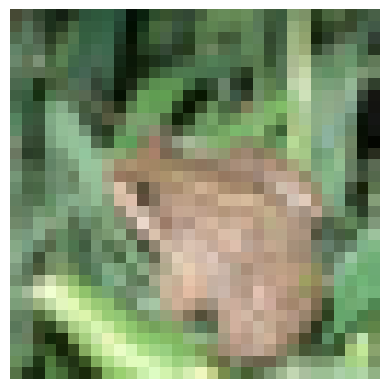

Global views:


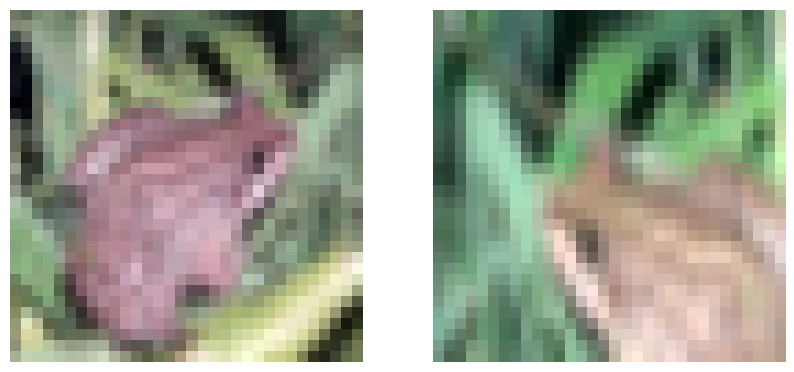

Local views:


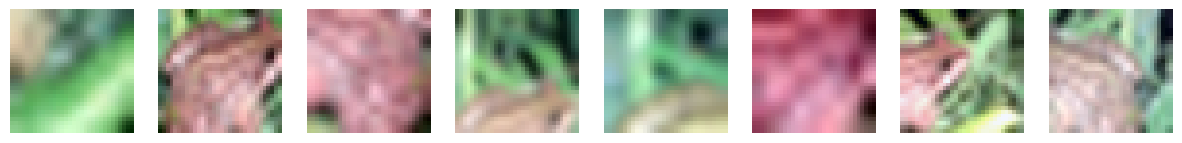

In [6]:
img_original, _ = dataset_original[4]
img_transformed, _ = dataset_transformed[4]

print("Original Image:")
imshow(img_original)

imshow(img_transformed)